In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!kaggle datasets download -d shanegerami/ai-vs-human-text

Dataset URL: https://www.kaggle.com/datasets/shanegerami/ai-vs-human-text
License(s): other
 96% 336M/350M [00:02<00:00, 113MB/s]
100% 350M/350M [00:02<00:00, 134MB/s]


In [5]:
!unzip /content/ai-vs-human-text.zip

Archive:  /content/ai-vs-human-text.zip
  inflating: AI_Human.csv            


In [6]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [8]:
import pandas as pd

# Read the dataset into a DataFrame
df = pd.read_csv('/content/AI_Human.csv')


In [9]:
df.head() #first rows

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


In [10]:
df.tail() #last rows

,text,generated
487230,Tie Face on Mars is really just a big misunder...,0.0
487231,The whole purpose of democracy is to create a ...,0.0
487232,I firmly believe that governments worldwide sh...,1.0
487233,I DFN't agree with this decision because a LFT...,0.0
487234,"Richard Non, Jimmy Carter, and Bob Dole and ot...",0.0


In [11]:
df.shape #shape of data

(487235, 2)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487235 entries, 0 to 487234
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       487235 non-null  object 
 1   generated  487235 non-null  float64
dtypes: float64(1), object(1)
memory usage: 7.4+ MB


In [13]:
df.isnull().sum()

,0
text,0
generated,0


In [14]:
df['generated'].value_counts() #value counts of generated col

,count
generated,
0.0,305797
1.0,181438


In [15]:
df['generated'] = df['generated'].astype(int) #convert that float to int

In [16]:
df['generated'].value_counts()

,count
generated,
0,305797
1,181438


In [17]:
df_0 = df[df['generated'] == 0].copy() # Creates a subset of the original DataFrame where the 'generated' column is 0.
df_1 = df[df['generated'] == 1].copy() #Creates a subset of the original DataFrame where the 'generated' column is 1.

In [18]:
df_0= df_0[:5000] #Limits the number of samples for class 0 to the first 5000 rows.
df_1= df_1[:5000] #Limits the number of samples for class  1 to the first 5000 rows.


In [19]:
df = pd.concat([df_0,df_1], ignore_index=True) #Concatenates the balanced subsets into a new DataFrame df. The ignore_index=True resets the index of the resulting DataFrame.
df.shape   #this is balanced new df taken from original df

(10000, 2)

<ipython-input-20-228fdb9f8805>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='generated', data=df, palette=custom_palette)
<ipython-input-20-228fdb9f8805>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(class_names)


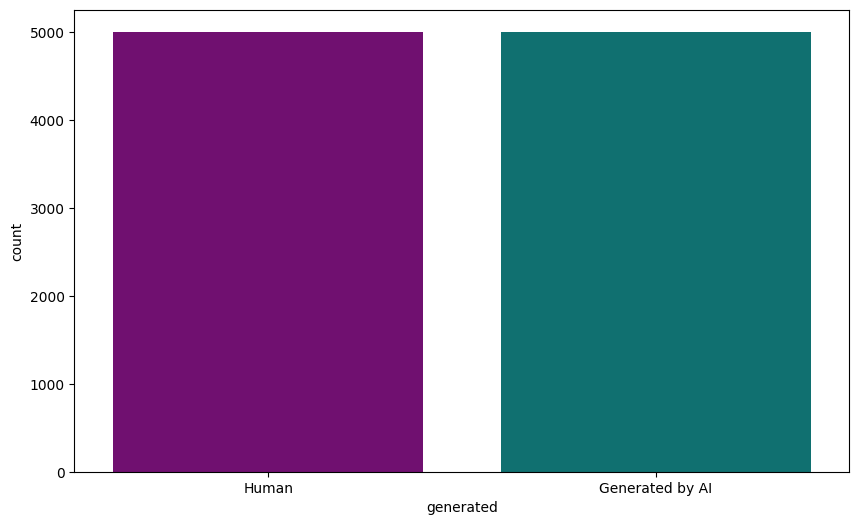

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the figure size
plt.figure(figsize=(10, 6))
class_names = ['Human', 'Generated by AI']
custom_palette = ['Purple', 'teal']

sns.countplot(x='generated', data=df, palette=custom_palette)

plt.gca().set_xticklabels(class_names)

plt.show()

# **Text Preprocessing**


#LowerCase

In [21]:
#Convert all text to lowercase.It helps in treating the same words consistently.
df['text'] = df['text'].str.lower()

# Tokenization

In [22]:
#breaking text into words
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

df['tokens'] = df['text'].apply(word_tokenize)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Removing Spcl Char and Num

In [23]:
#Removing spcl characters and numbers that may not contribute much to the understanding of the text.
df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word.isalpha()])

#Stopwords

In [24]:
#removing common words that do not carry much meaning
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in stop_words])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#Lemmatization

In [25]:
#Reduce words to their base form. This helps in reducing inflected words to a common base form
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


#Joining Tokens back to Text

In [26]:
#Convert the preprocessed tokens back to a text representation.
df['preprocessed_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))


#removing emptyrows

In [27]:
df = df[df['preprocessed_text'].notnull()]
#In some cases, preprocessing might result in empty rows. Remove such rows

In [28]:
df #here we have 4 columns we have to select relavent cols

,text,generated,tokens,preprocessed_text
0,cars. cars have been around since they became ...,0,"[car, car, around, since, became, famous, henr...",car car around since became famous henry ford ...
1,transportation is a large necessity in most co...,0,"[transportation, large, necessity, country, wo...",transportation large necessity country worldwi...
2,"""america's love affair with it's vehicles seem...",0,"[america, love, affair, vehicle, seems, coolin...",america love affair vehicle seems cooling say ...
3,how often do you ride in a car? do you drive a...,0,"[often, ride, car, drive, one, motor, vehicle,...",often ride car drive one motor vehicle work st...
4,cars are a wonderful thing. they are perhaps o...,0,"[car, wonderful, thing, perhaps, one, world, g...",car wonderful thing perhaps one world greatest...
...,...,...,...,...
9995,"famous people are often in the public eye, and...",1,"[famous, people, often, public, eye, private, ...",famous people often public eye private life fr...
9996,famous people have always been the center of a...,1,"[famous, people, always, center, attention, ri...",famous people always center attention rise soc...
9997,famous people are always under the watchful ey...,1,"[famous, people, always, watchful, eye, medium...",famous people always watchful eye medium const...
9998,celebrities have always been a subject of publ...,1,"[celebrity, always, subject, public, interest,...",celebrity always subject public interest life ...


In [29]:
# Create a new DataFrame with only the relevant columns
selected_columns = ['generated', 'preprocessed_text']
df_Final = df[selected_columns]

# Display the new DataFrame
print(df_Final.head())


   generated                                  preprocessed_text
0          0  car car around since became famous henry ford ...
1          0  transportation large necessity country worldwi...
2          0  america love affair vehicle seems cooling say ...
3          0  often ride car drive one motor vehicle work st...
4          0  car wonderful thing perhaps one world greatest...


In [30]:
df_Final.shape

(10000, 2)

#wordcloud

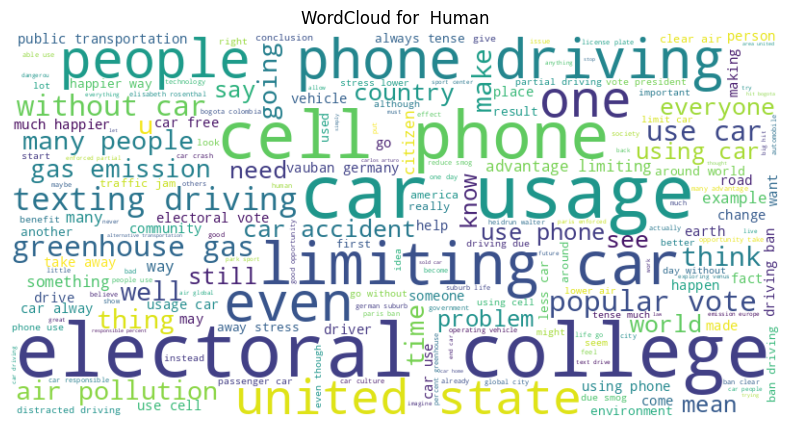

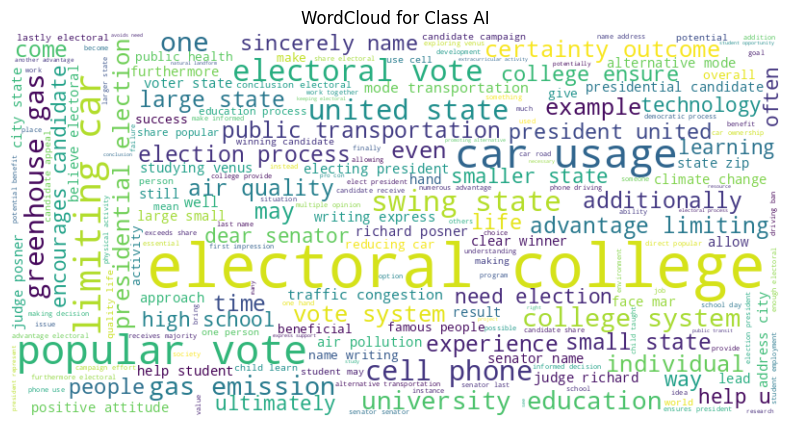

In [31]:
#wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Filter DataFrame for class 0
df_class_0 = df_Final[df_Final['generated'] == 0]

# Generate WordCloud for class 0
wordcloud_class_0 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_class_0['preprocessed_text']))

# Plot WordCloud for class 0
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_class_0, interpolation='bilinear')
plt.title('WordCloud for  Human')
plt.axis('off')
plt.show()

# Filter DataFrame for class 1
df_class_1 = df_Final[df_Final['generated'] == 1]

# Generate WordCloud for class 1
wordcloud_class_1 = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_class_1['preprocessed_text']))

# Plot WordCloud for class 1
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_class_1, interpolation='bilinear')
plt.title('WordCloud for Class AI')
plt.axis('off')
plt.show()


#train text split

In [32]:
from sklearn.model_selection import train_test_split

X = df_Final['preprocessed_text']
y = df_Final['generated']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Vectorize Text Data

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Convert the preprocessed text data into numerical format using techniques like TF-IDF

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


#MODEL

In [34]:
from sklearn.svm import SVC
# Create and train the SVM model
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)

# Evaluate the SVM model on the test set
svm_predictions = svm_model.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, svm_predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, svm_predictions))

# Evaluate on the training set
train_predictions = svm_model.predict(X_train_tfidf)

print("Training Classification Report:\n", classification_report(y_train, train_predictions))

# Evaluate on the test set
test_predictions = svm_model.predict(X_test_tfidf)

print("\nTesting Classification Report:\n", classification_report(y_test, test_predictions))


Accuracy: 0.9975

Confusion Matrix:
 [[1012    0]
 [   5  983]]
Training Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3988
           1       1.00      1.00      1.00      4012

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000


Testing Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1012
           1       1.00      0.99      1.00       988

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



In [35]:
from sklearn.naive_bayes import MultinomialNB
#Choose a classification algorithm and train the model using the vectorized text data
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)


MultinomialNB()

In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#Evaluate the trained model on the test set to assess its performance.
predictions = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, predictions))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, predictions))

# Evaluate on the training set
train_predictions = model.predict(X_train_tfidf)

print("Training Classification Report:\n", classification_report(y_train, train_predictions))

# Evaluate on the test set
test_predictions = model.predict(X_test_tfidf)

print("\nTesting Classification Report:\n", classification_report(y_test, test_predictions))



Accuracy: 0.9655

Confusion Matrix:
 [[993  19]
 [ 50 938]]
Training Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      3988
           1       0.98      0.96      0.97      4012

    accuracy                           0.97      8000
   macro avg       0.97      0.97      0.97      8000
weighted avg       0.97      0.97      0.97      8000


Testing Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97      1012
           1       0.98      0.95      0.96       988

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [37]:
df_Final.head(3)

,generated,preprocessed_text
0,0,car car around since became famous henry ford ...
1,0,transportation large necessity country worldwi...
2,0,america love affair vehicle seems cooling say ...


In [38]:
df_Final.tail(3)

,generated,preprocessed_text
9997,1,famous people always watchful eye medium const...
9998,1,celebrity always subject public interest life ...
9999,1,famous people always center public attention c...


ai = 1
human = 0

#Testing

In [39]:
new_data = ["failure common occurrence one everyone must"]
new_data_tfidf = tfidf_vectorizer.transform(new_data)
predictions = svm_model.predict(new_data_tfidf)

print("SVM Predictions:")
print(predictions)

SVM Predictions:
[1]


In [40]:
new_data = ["america love affair vehicle seems cooling say"]
new_data_tfidf = tfidf_vectorizer.transform(new_data)
predictions = svm_model.predict(new_data_tfidf)

print("SVM Predictions:")
print(predictions)

SVM Predictions:
[1]


In [41]:
new_data = ["failure common occurrence one everyone must"]
new_data_tfidf = tfidf_vectorizer.transform(new_data)
nb_predictions = model.predict(new_data_tfidf)

print("Naive Bayes Predictions:")
print(nb_predictions)

Naive Bayes Predictions:
[1]


In [42]:
new_data = ["america love affair vehicle seems cooling say"]
new_data_tfidf = tfidf_vectorizer.transform(new_data)
nb_predictions = model.predict(new_data_tfidf)

print("Naive Bayes Predictions:")
print(nb_predictions)

Naive Bayes Predictions:
[0]


In [59]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [43]:
import pickle

In [60]:
file = open("classifier.pkl","wb")
pickle.dump(model,file)
file.close()

In [ ]:
from flask import Flask, request
import pickle

# Load your model
try:
    with open('classifier.pkl', 'rb') as f:
        model = pickle.load(f)
except FileNotFoundError:
    raise Exception("The 'classifier.pkl' file was not found. Please ensure the file exists in the specified location.")

app = Flask(__name__)

@app.route("/")
def home():
    return "<h1>Hello, world!</h1>"

@app.route("/predict")
def predict():
    sample_input = request.args.get("text")
    if not sample_input:
        return "<h1>Error: 'text' parameter is required</h1>"

    # Process input for prediction
    processed_input = [sample_input.split()]
    try:
        prediction = model.predict(processed_input)
        return f"<h1>Prediction: {prediction[0]}</h1>"
    except Exception as e:
        return f"<h1>Error in prediction: {str(e)}</h1>"

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000, debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://172.28.0.12:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with stat
